In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [294]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train.shape, test.shape

((891, 12), (418, 11))

In [295]:
train = train.fillna(0)
test  = test.fillna(0)
train.shape, test.shape

((891, 12), (418, 11))

In [296]:
import category_encoders as ce

features = ['Pclass', 'Age', 'Fare']
target = 'Survived'

X_train = train[features][:418]
X_test  = test[features][:418]
y_train = train[target][:418]
y_test  = train[target][:418]

encoder = ce.OneHotEncoder(use_cat_names=True)
# imputer = SimpleImputer()

# X_train = encoder.fit_transform(X_train)
# X_test  = encoder.transform(X_test)
# X_train = imputer.fit_transform(X_train)
# X_test  = imputer.transform(X_test)

X_train.sample(n=10)

,Pclass,Age,Fare
58,2,5.0,27.7500
354,3,0.0,7.2250
24,3,8.0,21.0750
161,2,40.0,15.7500
371,3,18.0,6.4958
214,3,0.0,7.7500
190,2,32.0,13.0000
195,1,58.0,146.5208
258,1,35.0,512.3292
163,3,17.0,8.6625


In [297]:
y_train.head(2)

0    0
1    1
Name: Survived, dtype: int64

In [298]:
X_train.head(3)

,Pclass,Age,Fare
0,3,22.0,7.2500
1,1,38.0,71.2833
2,3,26.0,7.9250


In [299]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018BC0074358>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018BC0F516D8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [300]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.6320587733316365


In [301]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [302]:
X_test.shape, y_test.shape

((418, 3), (418,))

In [303]:
from sklearn.metrics import roc_auc_score
best = search.best_estimator_
X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.4628172741489234


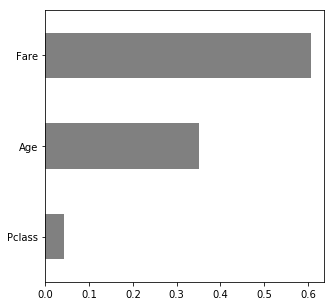

In [304]:
n = 20
figsize = (5,5)

importances = pd.Series(best.feature_importances_,X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='gray');

In [305]:
# X_train = X_train.dropna(axis=1)
# X_test  = X_test.dropna(axis=1)
# y_test = y_test.dropna(axis=1)
# y_train = y_train.dropna(axis=1)

# train = train.dropna(axis=1)
# test = test.dropna(axis=1)

In [306]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit', n_iter=2, random_state=42)#instantiate permuter object

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [307]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
-0.0098 ± 0.0099,Age
-0.0157 ± 0.0259,Fare
-0.0328 ± 0.0097,Pclass


In [308]:
X_test.head(2)

,Pclass,Age,Fare
0,3,34.5,7.8292
1,3,47.0,7.0000


In [309]:
print('Shape before removing features:', X_train.shape)# 

Shape before removing features: (418, 3)


In [310]:
permuter.feature_importances_

array([-0.03281006, -0.00982798, -0.01569229])

In [311]:
mask = permuter.feature_importances_ > -3 #confert to true and false greater than 0
features = X_train.columns[mask]#only features in order with non-zero importance
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (418, 3)


In [312]:
# Refit the model after we remove features with zero importance

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018BC003A470>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018BC003A278>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [313]:
from sklearn.model_selection import GridSearchCV

print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.6320587733316365


In [314]:
best = search.best_estimator_
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.4628172741489234


In [315]:
X_test.head(2)

,Pclass,Age,Fare
0,3,34.5,7.8292
1,3,47.0,7.0000


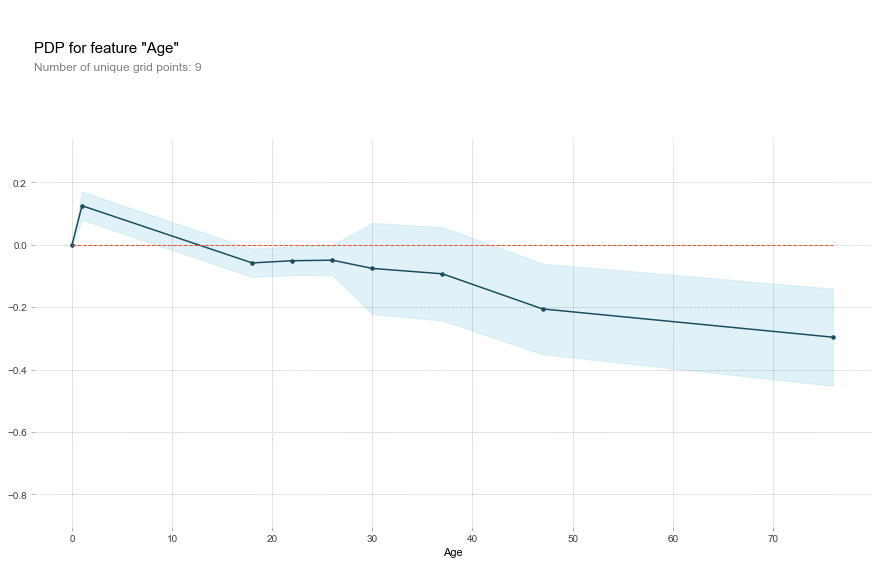

In [316]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'Age'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

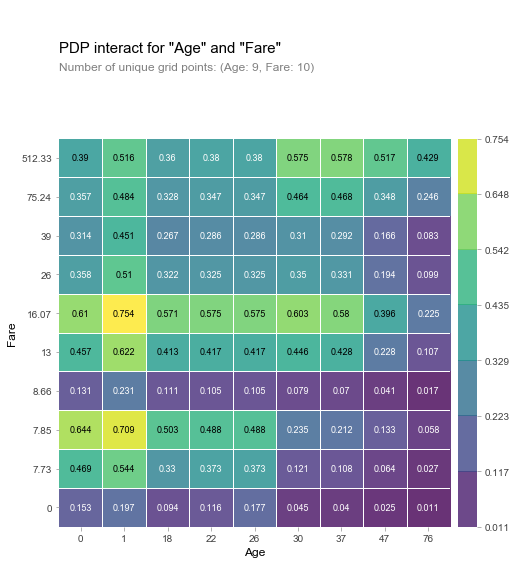

In [317]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Age','Fare']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [318]:
data_for_prediction = X_test[X_test.index==9]#get info for this instance, pass value into shaply function
data_for_prediction

,Pclass,Age,Fare
9,3,21.0,24.15


In [319]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)